In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam
import torch.nn.functional as F

In [2]:
from skimage.io import imread

In [3]:
FRAME_PATH = "/datadrive/faces/"

In [4]:
from os import path
import os
from tqdm import tqdm

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def fixname(s):
    return s.split('_')[2]

speakers = {}
for s in tqdm(os.listdir(FRAME_PATH)):
    PATH = path.join(FRAME_PATH, s)
    speakers[s] = {}
    for folder in os.listdir(PATH):
        PATH2 = path.join(PATH, folder)
        speakers[s][fixname(folder)] = []
        for filename in sorted(os.listdir(PATH2), key=lambda x: int(x.split('_')[1].split('.')[0])):
            speakers[s][fixname(folder)].append(imread(path.join(PATH2, filename)))

  0%|          | 0/33 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [7]:
import joblib

#joblib.dump(speakers, "/datadrive/speakers.joblib")

In [8]:
speakers = joblib.load("/datadrive/speakers.joblib")

In [10]:
WORD_PATH = "/home/mavrandr/gridcorpus/words/"

def fixname(s):
    return s.split('.')[0]

word_alignments = {}
for s in tqdm(os.listdir(WORD_PATH)):
    PATH = path.join(WORD_PATH, s, "align")
    word_alignments[s] = {}
    for filename in os.listdir(PATH):
        word_alignments[s][fixname(filename)] = []
        with open(path.join(PATH, filename)) as ftr:
            for line in ftr:
                l1, l2, w = line.split()
                l1 = round(int(l1) / 1000) - 1
                l2 = round(int(l2) / 1000) + 1
                word_alignments[s][fixname(filename)].append((w, l1, l2))

100%|██████████| 34/34 [00:02<00:00, 13.37it/s]


In [9]:
word_alignments['s1']['sbbu1s']

NameError: name 'word_alignments' is not defined

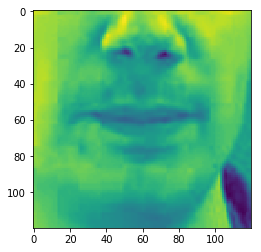

In [12]:
plt.imshow(speakers['s1']['sbbu1s'][0])

In [16]:
import numpy as np

MAX_WORDS = 8
MAX_FRAMES = 8
for_valida = ["s5", "s14"]

def encode_words(s):
    res = []
    for word, _, _ in s:
        if word == 'sil':
            res.append(27)
        else:
            #print(word, s)
            res.extend(ord(a) - ord('a') + 1 for a in word)
            res.append(27)
    if s[-1][0] != 'sil':
        res.pop()
    return res

def generate_XY(speakers, word_alignments, words_lengths=(1, 2), frame_length=24, drop_rate=0.8):
    X, Y = [], []
    for s in speakers.keys():
        if s in for_valida:
            continue
        for vid in speakers[s].keys():
            if len(speakers[s][vid]) == 75 and vid in word_alignments[s] and np.random.rand() > drop_rate:
                length = np.random.choice(np.arange(*words_lengths)) 
                pos = np.random.choice(len(word_alignments[s][vid]) - length + 1)
                if word_alignments[s][vid][pos][0] == 'sil':
                    continue
                l, r = word_alignments[s][vid][pos][1], word_alignments[s][vid][pos + length - 1][2]
                l = max(0, l)
                if (r - l > frame_length):
                    continue
                X.append(speakers[s][vid][l:r])
                Y.append(encode_words(word_alignments[s][vid][pos:pos+length]))
    return X, Y

In [14]:
X, Y = generate_XY(speakers, word_alignments, drop_rate=0)

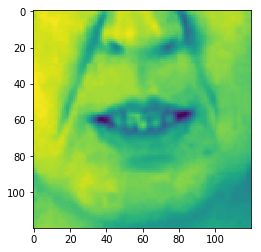

In [17]:
plt.imshow(X[0][0])

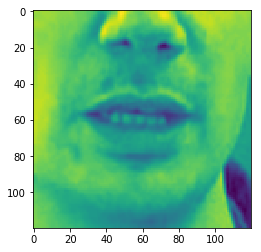

In [18]:
plt.imshow(speakers['s1']['sbbu1s'][10])

In [18]:
def add_zeros(X):
    max_len = max(len(x) for x in X)
    return np.array([x + [np.zeros((120, 120)) for i in range(max_len - len(x))] for x in X])

def iterate_batch(X, Y, batch_size=32):
    ind = np.arange(len(X))
    #np.random.shuffle(ind)
    #X = [X[i] for i in ind]
    #Y = [Y[i] for i in ind]
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], Y[i:i+batch_size]

In [20]:
class Flatten(nn.Module):
    def forward(self, x):
        out_x = x.transpose(1, 2)
        out_x = out_x.contiguous()
        dims = out_x.size()
        out_x = out_x.view(dims[0], dims[1], dims[2]*dims[3]*dims[4])
        return out_x

class LipNet(nn.Module):
    def __init__(self, hidden_size=256, vocab_size=28, n_layers=1, in_channels=1):
        super(LipNet, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.in_channels = in_channels
        self.conv1 = nn.Conv3d(in_channels=self.in_channels, out_channels=32, kernel_size=(3, 5, 5), 
                               stride=(1, 2, 2), padding=(1, 2, 2))
        self.pooling = nn.MaxPool3d((1, 2, 2))
        self.batchnorm1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3, 5, 5), 
                               stride=(1, 2, 2), padding=(1, 2, 2))
        self.batchnorm2 = nn.BatchNorm3d(64)
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=96, kernel_size=(3, 3, 3), 
                               stride=(1, 2, 2), padding=(1, 1, 1))
        self.batchnorm3 = nn.BatchNorm3d(96)
        self.flat = Flatten()
        self.gru1 = nn.GRU(input_size=384, hidden_size=hidden_size, num_layers=self.n_layers, 
                           bidirectional=True, batch_first=True)
        self.dense1 = nn.Linear(512, 28)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, input):
        output = F.relu(self.batchnorm1(self.conv1(input)))
        output = self.pooling(output)
        output = F.relu(self.batchnorm2(self.conv2(output)))
        output = self.pooling(output)
        output = F.relu(self.batchnorm3(self.conv3(output)))

        output = self.pooling(output)
        output = self.flat(output)
        #print(output.shape)
        output, hidden = self.gru1(output)
        output = self.dense1(output)
        #print(output.size())
        output = self.softmax(output)
        return output
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(2, batch_size, self.hidden_size))

In [106]:
model = LipNet().cuda()
optimizer = Adam(model.parameters(), lr=1e-4)

In [107]:
from warpctc_pytorch import CTCLoss

In [108]:
from tqdm import tqdm
from IPython.display import clear_output

n_epoch = 5
criterion = CTCLoss()
mean_loss = 0
loss_log = []
for epoch in range(n_epoch):
    X, Y = generate_XY(speakers, word_alignments, drop_rate=0.0, frame_length=10)
    for i, (x, y) in enumerate(tqdm(iterate_batch(X, Y))):
        x_lengths = Variable(torch.IntTensor([len(rx) for rx in x]))
        x = Variable(torch.FloatTensor(add_zeros([[tx for tx in rx] for rx in x]))).cuda()
        x = x.view(x.shape[0], 1, *x.shape[1:])
        y_lengths = Variable(torch.IntTensor([len(ry) for ry in y]))
        #print([z for by in y for z in by])
        y = Variable(torch.IntTensor([z for by in y for z in by]))
        #print(x_lengths.size(0), x.shape)
        optimizer.zero_grad()
        out = model(x).transpose(0, 1)
        loss = criterion(out, y, x_lengths, y_lengths) / x.size(0)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.data[0])
        clear_output()
        plt.plot(loss_log)
        plt.show()
            
        

KeyboardInterrupt: 

In [89]:
x_lengths

Variable containing:
 4
[torch.IntTensor of size 1]

In [90]:
y_lengths

Variable containing:
 3
[torch.IntTensor of size 1]

In [91]:
y

Variable containing:
 12
  1
 25
[torch.IntTensor of size 3]

In [98]:
out[3, 0]

Variable containing:
 0.0001
 0.0009
 0.0001
 0.0001
 0.0001
 0.0001
 0.0000
 0.0000
 0.0000
 0.0001
 0.0001
 0.0001
 0.0003
 0.0000
 0.0001
 0.0000
 0.0001
 0.0001
 0.0001
 0.0001
 0.0000
 0.0001
 0.0001
 0.0000
 0.0001
 0.9972
 0.0001
 0.0000
[torch.cuda.FloatTensor of size 28 (GPU 0)]

In [39]:
x, y = next(iterate_batch(X, Y))

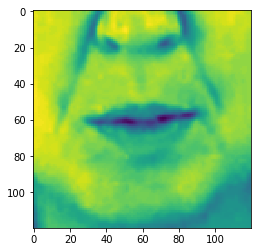

In [158]:
plt.imshow(X[1][4])

In [150]:
Y[1]

[2, 9, 14]

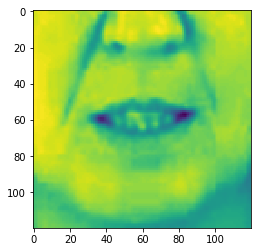

In [133]:
plt.imshow(X[0][2])

In [73]:
x_lengths = Variable(torch.IntTensor([len(rx) for rx in x]))
x = Variable(torch.FloatTensor(add_zeros([[tx / 256 for tx in rx] for rx in x]))).cuda()

KeyboardInterrupt: 

In [ ]:
#x_lengths = Variable(torch.IntTensor([len(rx) for rx in x]))
#x = Variable(torch.FloatTensor(add_zeros([[tx / 256 for tx in rx] for rx in x]))).cuda()
x = x.view(x.shape[0], 1, *x.shape[1:])
y_lengths = Variable(torch.IntTensor([len(ry) for ry in y]))
#print([z for by in y for z in by])
y = Variable(torch.IntTensor([z for by in y for z in by]))

In [ ]:
out = model(x).transpose(0, 1)

In [ ]:
out[10,6]

In [ ]:
torch.cuda.empty_cache()

In [13]:
import itertools

class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.batchnorm1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.batchnorm2 = nn.BatchNorm2d(20)
        self.conv3 = nn.Conv2d(20, 40, 3)
        self.batchnorm3 = nn.BatchNorm3d(30)
        self.gru_encoder = nn.GRU(num_layers=1, hidden_size=128, input_size=360, batch_first=True, bidirectional=True)
        self.embedding = nn.Embedding(num_embeddings=29, embedding_dim=14)
        self.linear = nn.Linear(256, 128)
        self.gru_decoder_cell = nn.GRUCell(hidden_size=128, input_size=14)
        self.output = nn.Linear(out_features=29, in_features=128)
        
    def start(self, batch_size):
        return Variable(torch.from_numpy(np.repeat(28, batch_size))).cuda()
                                  
    def forward(self, input, output):
        input = input.transpose(1, 2).contiguous()
        shape = input.shape[:2][:]
        input = input.view((-1, *input.shape[2:]))
        out = F.relu(F.max_pool2d(self.conv1(input), 3))
        out = F.relu(F.max_pool2d(self.conv2(out), 3))
        out = F.relu(F.max_pool2d(self.conv3(out), 3))
        out = out.view((*shape, *out.shape[1:]))
        out = out.view((*out.shape[:2], -1)).contiguous()
        #print(out.shape)
        out, hidden = self.gru_encoder(out)
        dec_h = F.tanh(self.linear(out[:,-1]))
        logits = []
        #print(dec_h.shape)
        #print(output.transpose(0, 1).shape)
        for x in itertools.chain((self.start(output.size(0)),), output.transpose(0, 1)[:-1]):
            dec_h = self.gru_decoder_cell(self.embedding(x), dec_h)
            #print(dec_h.shape)
            logits.append(self.output(dec_h))
        return F.log_softmax(torch.stack(logits, dim=1), dim=-1) 
    
    def greedy_inference(self, input):
        model.eval()
        input = input.transpose(1, 2).contiguous()
        shape = input.shape[:2][:]
        input = input.view((-1, *input.shape[2:]))
        out = F.relu(F.max_pool2d(self.conv1(input), 3))
        out = F.relu(F.max_pool2d(self.conv2(out), 3))
        out = F.relu(F.max_pool2d(self.conv3(out), 3))
        out = out.view((*shape, *out.shape[1:]))
        out = out.view((*out.shape[:2], -1)).contiguous()
        #print(out.shape)
        out, hidden = self.gru_encoder(out)
        dec_h = F.tanh(self.linear(out[:,-1]))
        char = self.start(1)
        ans = []
        for i in range(MAX_LEN):
            dec_h = self.gru_decoder_cell(self.embedding(char), dec_h)
            char = self.output(dec_h).max(1)[1]
            ans.append(char.data[0])
        return ans
            

In [46]:
model = EncoderDecoder().cuda()
optimizer = Adam(model.parameters())

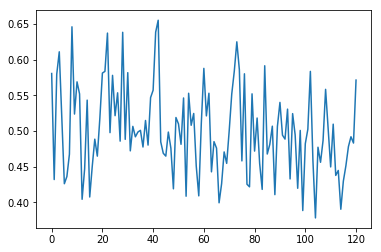

148it [00:26,  5.56it/s]

In [ ]:
import itertools
from tqdm import tqdm
from IPython.display import clear_output

n_epoch = 20
criterion = nn.CrossEntropyLoss()
loss_log = []
MAX_LEN = 14
for epoch in range(n_epoch):
    X, Y = generate_XY(speakers, word_alignments, drop_rate=0.0, words_lengths=(1, 3), frame_length=36)
    for i, (x, y) in enumerate(tqdm(iterate_batch(X, Y, 16))):
        x = Variable(torch.FloatTensor(add_zeros([[tx for tx in rx] for rx in x]))).cuda() / 100
        x = x.view(x.shape[0], 1, *x.shape[1:])
        y = Variable(torch.LongTensor([ry + [0] * (MAX_LEN - len(ry)) for ry in y])).cuda()
        #print(x_lengths.size(0), x.shape)
        optimizer.zero_grad()
        out = model(x, y).transpose(0, 1)
        y = y.transpose(0, 1)
        #print(out.shape)
        for j, (outc, yc) in enumerate(zip(out, y)):
            if j == 0:
                loss = criterion(outc, yc)
            else:
                loss += criterion(outc, yc)
        loss /= MAX_LEN
        loss.backward()
        optimizer.step()
        loss_log.append(loss.data[0])
        if i % 30 == 0:
            clear_output()
            plt.plot(loss_log)
            plt.show()

In [288]:
model.greedy_inference(x[5:6])

[16, 12, 5, 1, 19, 5, 0]

In [265]:
y[5:6].data


    7    18     5     5    14     0     0
[torch.cuda.LongTensor of size 1x7 (GPU 0)]

In [48]:
def decode_labels(x):
    return ''.join([chr(ord('a') + i - 1) for i in x if i])

In [49]:
for i in range(16):
    print(decode_labels(model.greedy_inference(x[i:i+1])), decode_labels(y[i:i+1].data[0]))

by white
b in
soon{{ eight{now
by set
by by
set{red x{five
set{red q{eight
soon{{ again{{
set{red q{eight
set six
by red
by green
by in
by in{z
by p
by red


In [44]:
x[1:2]

[[array([[162, 163, 163, ..., 156, 155, 155],
         [161, 162, 162, ..., 156, 155, 155],
         [160, 161, 162, ..., 156, 156, 156],
         ..., 
         [ 67,  67,  68, ..., 116, 116, 116],
         [ 70,  70,  70, ..., 117, 117, 117],
         [ 71,  72,  72, ..., 117, 117, 117]], dtype=uint8),
  array([[162, 163, 163, ..., 156, 155, 155],
         [161, 162, 162, ..., 156, 155, 155],
         [160, 161, 162, ..., 156, 156, 156],
         ..., 
         [ 67,  67,  68, ..., 116, 116, 116],
         [ 70,  70,  70, ..., 117, 117, 117],
         [ 71,  72,  72, ..., 117, 117, 117]], dtype=uint8),
  array([[162, 163, 163, ..., 156, 155, 155],
         [161, 162, 162, ..., 156, 155, 155],
         [160, 161, 162, ..., 156, 156, 156],
         ..., 
         [ 68,  68,  68, ..., 116, 115, 115],
         [ 71,  70,  70, ..., 117, 116, 116],
         [ 73,  72,  71, ..., 117, 116, 116]], dtype=uint8),
  array([[162, 163, 163, ..., 156, 156, 156],
         [161, 162, 162, ..., 156, 1

'again'

In [292]:
model.train()

EncoderDecoder(
  (conv1): Conv2d (1, 10, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d (10, 20, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d (20, 40, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm3d(30, eps=1e-05, momentum=0.1, affine=True)
  (gru_encoder): GRU(360, 128, batch_first=True, bidirectional=True)
  (embedding): Embedding(29, 14)
  (linear): Linear(in_features=256, out_features=128)
  (gru_decoder_cell): GRUCell(14, 128)
  (output): Linear(in_features=128, out_features=29)
)

In [280]:
y[5:6].data[0]


  7
 18
  5
  5
 14
  0
  0
[torch.cuda.LongTensor of size 7 (GPU 0)]